[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/me-manu/gammaALPs/blob/master/docs/tutorials/photon_dispersion.ipynb)

# Photon-photon dispersion

This tutorial shows how to include photon-photon dispersion off of background photon fields in the ALP-photon propagation calculation. The relevance of photon dispersion for ALP calculations is discussed in [Dobrynina 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.91.083003). A background field adds to the dispersive part of the refractive index of the propagation medium $n = 1+\chi$. [Dobrynina 2015](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.91.083003) show that at $z=0$, $\chi_{CMB} = 5.11\times10^{-43}$. Dispersion off the CMB is included by default, but other values of $\chi$ can be included manually.

If you haven't installed `gammaALPs` already, you can do so using `pip`. Just uncomment the line below:

In [1]:
#!pip install gammaALPs

First import what we will need:

In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as c
from matplotlib.patheffects import withStroke
from astropy import units as u
import time
from scipy.interpolate import RectBivariateSpline as RBSpline

effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

$\chi$ is included in the code as a 2D spline function in energy and propagation distance. This means that the points at which $\chi$ is calculated at do not need to be exactly the same as the points used for the magnetic field. It is also possible to include $\chi$ as an array of size `(1)` if you want a constant value, or size `(len(EGeV),len(r))`, if you have calculated $\chi$ in the exact magnetic field domains you will be using.

## $\chi$ function

We will create a fake $\chi$ function which changes with distance and energy, and then see its effects on mixing in different environments.

In [3]:
EGeV = np.logspace(-5.,6.,1000)

In [4]:
chiCMB = transfer.chiCMB

In [5]:
chiCMB

5.0962922355799666e-43

$r$ will be in pc for the jets and kpc for the clusters and GMF.

In [6]:
rs = np.logspace(-2,5,200)
chis = 1.e9 * rs[np.newaxis,:]**-3 * chiCMB * EGeV[:,np.newaxis]**(1.5) + chiCMB

Text(0.5, 0, 'r [pc or kpc] or z')

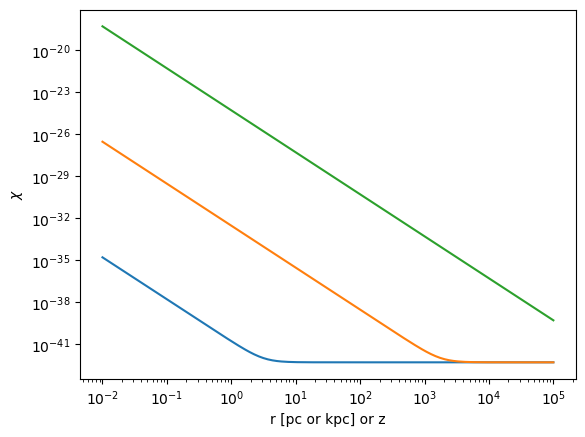

In [7]:
plt.loglog(rs,chis[0,:])
plt.loglog(rs,chis[500,:])
plt.loglog(rs,chis[-1,:])
plt.ylabel(r'$\chi$')
plt.xlabel('r [pc or kpc] or z')

Our $\chi$ changes with both energy and distance.

Text(0, 0.5, 'r [pc or kpc]')

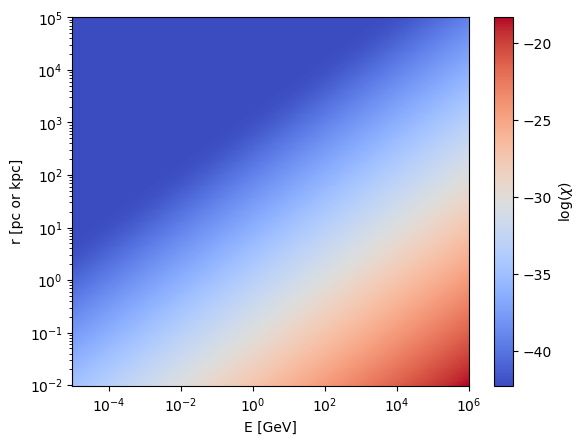

In [8]:
ee, rr = np.meshgrid(EGeV,rs,indexing='ij')
plt.pcolormesh(ee,rr,np.log10(chis),cmap=plt.get_cmap('coolwarm'),
               shading='auto')
plt.colorbar(label=r"log($\chi$)")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('E [GeV]')
plt.ylabel('r [pc or kpc]')

Make the spline function:

In [9]:
chispl = RBSpline(EGeV,rs,chis,kx=1,ky=1,s=0)

Now we can test it for a source. We will use 3C454.3 (see the individual environment tutorials for more details on each of the environments).

In [10]:
src = Source(z=0.859 , ra='22h53m57.7s', dec='+16d08m54s', bLorentz=60.)  # 3C454.3

In [11]:
pin = np.diag((1.,1.,0.)) * 0.5

## Jet

First, let's test the `"Jet"` class:

In [12]:
ml = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)
ml_chi = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)

In [13]:
# other jet
gamma_min = 18.

Add the same jet module to each, including $\chi$ with the `chi` keyword for the second one.

In [14]:
ml.add_propagation("Jet", 
                  0,  # position of module counted from the source. 
                  B0=0.32,  # Jet field at r = R0 in G 
                  r0=1.,  # distance from BH where B = B0 in pc
                  rgam=3.19e17 * u.cm.to('pc'),  # distance of gamma-ray emitting region to BH
                  alpha=-1.,  # exponent of toroidal mangetic field (default: -1.)
                  psi=np.pi/4.,  # Angle between one photon polarization state and B field. 
                                 # Assumed constant over entire jet. 
                  helical=True,  # if True, use helical magnetic-field model from Clausen-Brown et al. (2011). 
                                 # In this case, the psi kwarg is treated is as the phi angle 
                                 # of the photon trajectory in the cylindrical jet coordinate system
                  equipartition=True,  # if true, assume equipartition between electrons and the B field. 
                                       # This will overwrite the exponent of electron density beta = 2 * alpha 
                                       # and set n0 given the minimum electron lorentz factor set with gamma_min
                  gamma_min=gamma_min,  # minimum lorentz factor of emitting electrons, only used if equipartition=True
                  gamma_max=np.exp(10.) * gamma_min,  # maximum lorentz factor of emitting electrons,
                                                      # only used if equipartition=True
                  Rjet= 40.,  # maximum jet length in pc (default: 1000.)
                  n0=1e4,  # normalization of electron density, overwritten if equipartition=True
                  beta=-2.    # power-law index of electron density, overwritten if equipartition=True
                 )
ml_chi.add_propagation("Jet", 
                  0,  # position of module counted from the source. 
                  B0=0.32,  # Jet field at r = R0 in G 
                  r0=1.,  # distance from BH where B = B0 in pc
                  rgam=3.19e17 * u.cm.to('pc'),  # distance of gamma-ray emitting region to BH
                  alpha=-1.,  # exponent of toroidal mangetic field (default: -1.)
                  psi=np.pi/4.,  # Angle between one photon polarization state and B field. 
                                 # Assumed constant over entire jet. 
                  helical=True,  # if True, use helical magnetic-field model from Clausen-Brown et al. (2011). 
                                 # In this case, the psi kwarg is treated is as the phi angle 
                                 # of the photon trajectory in the cylindrical jet coordinate system
                  equipartition=True,  # if true, assume equipartition between electrons and the B field. 
                                       # This will overwrite the exponent of electron density beta = 2 * alpha 
                                       # and set n0 given the minimum electron lorentz factor set with gamma_min
                  gamma_min=gamma_min,  # minimum lorentz factor of emitting electrons, only used if equipartition=True
                  gamma_max=np.exp(10.) * gamma_min,  # maximum lorentz factor of emitting electrons,
                                                      # only used if equipartition=True
                  Rjet= 40.,  # maximum jet length in pc (default: 1000.)
                  n0=1e4,  # normalization of electron density, overwritten if equipartition=True
                  beta=-2.,    # power-law index of electron density, overwritten if equipartition=True
                  chi=chispl    
                 )

environs.py: 758 --- INFO: Assuming equipartion at r0: n0(r0) = 6.307e-01 cm^-3
environs.py: 767 --- INFO: Using inputted chi
environs.py: 758 --- INFO: Assuming equipartion at r0: n0(r0) = 6.307e-01 cm^-3
environs.py: 764 --- INFO: Using interpolated chi


Pick a mass and coupling where there is some mixing, and run the calculation for each.

In [15]:
ml.alp.m = 100.
ml.alp.g = 0.3

ml_chi.alp.m = 100.
ml_chi.alp.g = 0.3

In [16]:
px, py, pa = ml.run()
pgg = px + py  

px_c, py_c, pa_c = ml_chi.run()
pgg_chi = px_c + py_c  

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixJet'>
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:799: UserWarning: Not all values of linear polarization are real values!
  warnings.warn("Not all values of linear polarization are real values!")
/Users/mey/Python/gammaALPs/gammaALPs/base/transfer.py:802: UserWarning: Not all values of circular polarization are real values!
  warnings.warn("Not all values of circular polarization are real values!")
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixJet'>


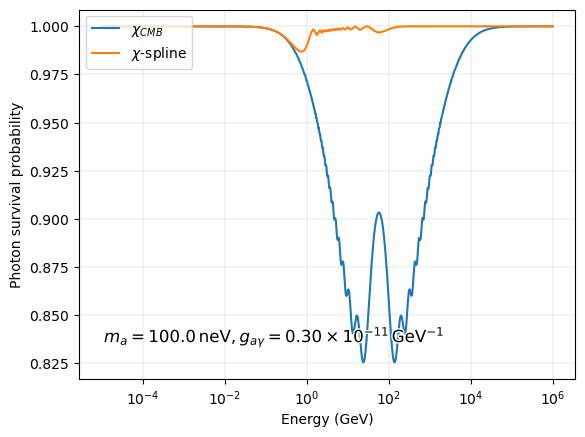

In [17]:
for p in pgg: 
    plt.plot(ml.EGeV, p, label=r'$\chi_{CMB}$')
    
for p_c in pgg_chi: 
    plt.plot(ml_chi.EGeV, p_c, label=r'$\chi$-spline')

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',
             **effect)
plt.legend(loc='upper left')

The $P_{\gamma\gamma}$'s are quite different between the two cases. $\chi$ affects the mixing by lowering the high critical energy, $E_{crit}^{high}$, and so oftern reduces mixing at very high energies.

## Cluster

Now let's look at a cluster magnetic field, `"ICMGaussTurb"`. We can use the same $\chi$ array in $(E,r)$ but this time $r$ will be in kpc instead of pc.

In [18]:
# cluster
ml = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)
ml_chi = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)

In [19]:
ml.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field
                  n0=39.,  # normalization of electron density
                  n2=4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell=500., # extension of the cluster
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )
ml_chi.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=10.,  # rms of B field
                  n0=39.,  # normalization of electron density
                  n2=4.05, # second normalization of electron density, see Churazov et al. 2003, Eq. 4
                  r_abell=500., # extension of the cluster
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0, # random seed for reproducability, set to None for random seed.
                  chi = chispl
                 )

environs.py: 431 --- INFO: Using inputted chi
environs.py: 428 --- INFO: Using interpolated chi


In [20]:
ml.alp.m = 10.
ml.alp.g = 0.7

ml_chi.alp.m = 10.
ml_chi.alp.g = 0.7

In [21]:
px, py, pa = ml.run()
pgg = px + py  

px_c, py_c, pa_c = ml_chi.run()
pgg_chi = px_c + py_c  

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


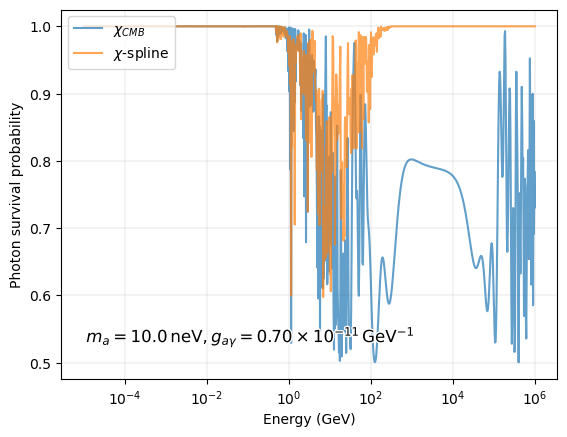

In [22]:
for pi,p in enumerate(pgg): 
    if pi==0:
        plt.plot(ml.EGeV, p, color=plt.cm.tab10(0.), alpha = 0.7, label=r'$\chi_{CMB}$')
    else:
        plt.plot(ml.EGeV, p, color=plt.cm.tab10(0.),alpha = 0.1)
    
for pi_c,p_c in enumerate(pgg_chi): 
    if pi_c==0:
        plt.plot(ml_chi.EGeV, p_c, color=plt.cm.tab10(1), alpha = 0.7, label=r'$\chi$-spline')
    else:
        plt.plot(ml_chi.EGeV, p_c, color=plt.cm.tab10(1),alpha = 0.1)

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',
             **effect)
plt.legend(loc='upper left')

Again, including $\chi$ lowers the highest energy at which there is strong mixing.

## GMF

For the GMF:

In [23]:
# GMF
ml = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)
ml_chi = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)

In [24]:
ml.add_propagation("GMF", 
                   0, 
                   model='jansson12')
ml_chi.add_propagation("GMF",
                       0, 
                       model='jansson12',
                       chi = chispl)

environs.py:1196 --- INFO: Using inputted chi
environs.py:1193 --- INFO: Using interpolated chi


In [25]:
ml.alp.m = 1.
ml.alp.g = 3.

ml_chi.alp.m = 1.
ml_chi.alp.g = 3.

In [26]:
px, py, pa = ml.run()
pgg = px + py  

px_c, py_c, pa_c = ml_chi.run()
pgg_chi = px_c + py_c  

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>


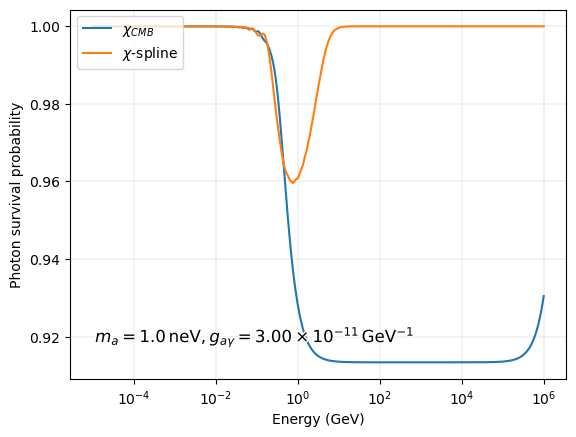

In [27]:
for p in pgg: 
    plt.plot(ml.EGeV, p, label=r'$\chi_{CMB}$')
    
for p_c in pgg_chi: 
    plt.plot(ml_chi.EGeV, p_c, label=r'$\chi$-spline')

plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',
             **effect)
plt.legend(loc='upper left')

The effect is the same.

## IGMF

Mixing in the IGMF is slightly different. Far from pair-produciton energies, $\chi \propto \rho$ where $\rho$ is the energy density of the background field. The energy density of the CMB evolves with redshift as $\rho \propto T^4 \propto (1+z)^4$. Therefore, by default, mixing in the IGMF doesn't use a constant value of $\chi_{CMB}$, but rather uses $\chi(z)=\chi_{CMB}(1+z)^4$ where $\chi_{CMB} = 5.11\times10^{-43}$ as mentioned above and is calculated at $z=0$. 

It is also possible to manually include a spline function for $\chi$ in the IGMF, but now the spline needs to be in energy and redshift instead of energy and distance:

In [28]:
zs = np.logspace(-1,np.log10(1.5),200)
chispl_z = RBSpline(EGeV,zs,chis,kx=1,ky=1,s=0)

In [29]:
# IGMF
ml = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)
ml_chi = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)
ml_chiz = ModuleList(ALP(m=1., g=2.), src, pin=pin, EGeV=EGeV, seed = 0)

For comparison we will also include a constant value of $\chi_{CMB}$. Any environment will accept a single value of chi in the form of `chi=np.array([chi])`.

In [30]:
ml.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez', # EBL model
                  chi = np.array([chiCMB])
                  )
ml_chi.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez', # EBL model
                 chi = chispl_z
                  )
ml_chiz.add_propagation("IGMF", 
                  0, # position of module counted from the source. 
                  nsim=1, # number of random B-field realizations
                  B0=1e-3,  # B field strength in micro Gauss at z = 0
                  n0=1e-7,  # normalization of electron density in cm^-3 at z = 0
                  L0=1e3, # coherence (cell) length in kpc at z = 0
                  eblmodel='dominguez' # EBL model
                  )

environs.py: 109 --- INFO: Using inputted chi
environs.py: 107 --- INFO: Using interpolated chi


In [31]:
ml.alp.m = 0.1
ml.alp.g = 3.

ml_chi.alp.m = 0.1
ml_chi.alp.g = 3.

ml_chiz.alp.m = 0.1
ml_chiz.alp.g = 3.

In [32]:
px, py, pa = ml.run()
pgg = px + py  

px_c, py_c, pa_c = ml_chi.run()
pgg_chi = px_c + py_c  

px_cz, py_cz, pa_cz = ml_chiz.run()
pgg_chiz = px_cz + py_cz 

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixIGMFCell'>


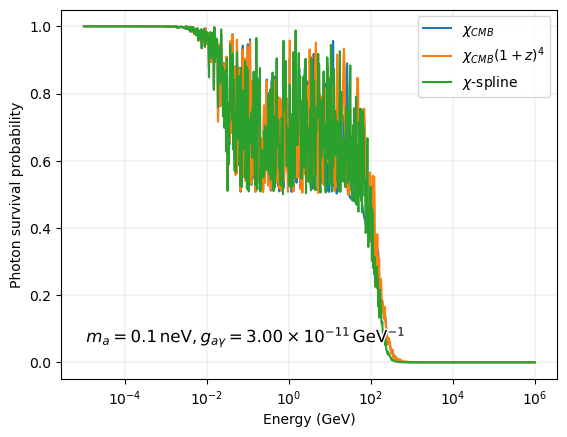

In [33]:
for p in pgg: 
    plt.plot(ml.EGeV, p, label=r'$\chi_{CMB}$')
    
for p_cz in pgg_chiz: 
    plt.plot(ml_chiz.EGeV, p_cz, label=r'$\chi_{CMB} (1+z)^4$')

for p_c in pgg_chi: 
    plt.plot(ml_chi.EGeV, p_c, label=r'$\chi$-spline')
    
plt.grid(True, lw = 0.2)
plt.grid(True, which = 'minor', axis = 'y', lw = 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel(r'Photon survival probability')

plt.gca().set_xscale('log')
plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.2f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m,ml.alp.g),
             xy=(0.05,0.1),
             size='large',
             xycoords='axes fraction',
             ha='left',
             **effect)
plt.legend()

All three are different.